In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

sns.set_style(style='white')
sns.set_context(context ='paper')

pd.set_option('max_columns',50)
pd.set_option('max_rows',500)

font_path = 'NanumSquareRoundR.ttf'
fontprop = fm.FontProperties(fname=font_path, size = 15)

In [83]:
out_until181016 = pd.read_csv('outdoor_until_181016.csv')

In [84]:
out17 = pd.read_csv('day17_outoor.csv', encoding  = 'euc-kr')

In [101]:
p8 = pd.read_csv('publicday8.csv',index_col = '측정소명')
p9 = pd.read_csv('publicday9.csv',index_col = '측정소명')
p10 = pd.read_csv('publicday10.csv',index_col = '측정소명')
p11 = pd.read_csv('publicday11.csv',index_col = '측정소명')
p12 = pd.read_csv('publicday12.csv',index_col = '측정소명')
p13 = pd.read_csv('publicday13.csv',index_col = '측정소명')
p14 = pd.read_csv('publicday14.csv',index_col = '측정소명')

# 전처리

In [103]:
def preprocessing_1(out):
    out.columns = ['SENSOR_ID', 'MEASURE_DTTM', 'LAT',
               'LON', 'TOTAL_ADDR', 'PM1',
               'PM2', 'PM10', 'TEMPER',
               'HUMI', 'TVOC', 'CO2',
               'FORMALDEHYDE', 'BATTERY_INFO', 'SPEED',
               'ILLUMINATION', 'ACCELERATE', 'USE_YN']   
    out.dropna(subset = ['TOTAL_ADDR','PM2'], inplace = True)
    out.reset_index(drop = True, inplace = True)
    ### PM2의 이상치 제거 : PM2 상위 99.9% 이상의 값은 지움(for 시각화)
    out = out[out.PM2 < out.PM2.quantile(0.999)]

In [ ]:
preprocessing_1(out_until181016)
preprocessing_1(out17)

In [105]:
# xtick 그리기
xtick = list()

for i in range(24):
    xtick.append(str(i+1))

### 공공데이터 만들기 : 공공데이터의 경우 '에어코리아'에서 데이터를 복붙해서 table을 만들었습니다.
- 8일~14일, 1시~24시, 서울PM2의 평균입니다.

In [111]:
# 공공데이터
def change(x):
    if x == '-':
        return 0
    else:
        return x
    
p12.dropna(inplace = True)    
p13.dropna(inplace = True)
p14.dropna(inplace = True)


    
p8 = p8.applymap(change)
p8 = p8.applymap(int)

p9 = p9.applymap(change)
p9 = p9.applymap(int)

p10 = p10.applymap(change)
p10 = p10.applymap(int)

p11 = p11.applymap(change)
p11 = p11.applymap(int)


p12 = p12.applymap(change)
p12 = p12.applymap(int)

p13 = p13.applymap(change)
p13 = p13.applymap(int)

p14 = p14.applymap(change)
p14 = p14.applymap(int)

day8 = list()
for i in p8.columns:
    day8.append(p8[i].mean())
    
day9 = list()
for i in p9.columns:
    day9.append(p9[i].mean())
    
day10 = list()
for i in p10.columns:
    day10.append(p10[i].mean())
    
day11 = list()
for i in p11.columns:
    day11.append(p11[i].mean())
    
day12 = list()
for i in p12.columns:
    day12.append(p12[i].mean())

day13 = list()
for i in p13.columns:
    day13.append(p13[i].mean())
    
day14 = list()
for i in p14.columns:
    day14.append(p14[i].mean())
    
public = pd.DataFrame([day8,day9,day10,day11,day12,day13,day14])
public = public.T
public.columns = [8,9,10,11,12,13,14]
public.index = range(1,25)

In [91]:
def preprocessing_2(out):
    # 년
    year = list()

    for i in range(len(out)):
        year.append(int(out.MEASURE_DTTM[i].split(' ')[0].split('-')[0]))

    out['YEAR'] = year

    # 월

    month = list()

    for i in range(len(out)):
        month.append(int(out.MEASURE_DTTM[i].split(' ')[0].split('-')[1]))

    out['MONTH'] = month

    # 일

    d = list()

    for i in range(len(out)):
        d.append(int(out.MEASURE_DTTM[i].split(' ')[0].split('-')[2]))

    out['DAY'] = d

    # 시
    h = list()

    for i in range(len(out)):
        if out['MEASURE_DTTM'][i].split(' ')[1] == '오전':
            h.append(int(out['MEASURE_DTTM'][i].split(' ')[2].split(':')[0]))
        else:
            h.append(int(out['MEASURE_DTTM'][i].split(' ')[2].split(':')[0])+12)

    for i in range(len(h)):
        if h[i] == 12:
            h[i] = 24
        elif h[i] == 24:
            h[i] = 12

    out['HOUR'] = h

    # 분
    m = list()

    for i in range(len(out)):
        m.append(int(out['MEASURE_DTTM'][i].split(' ')[2].split(':')[1]))

    out['MINUTE'] = m

    # 지역
    region_1 = list()
    region_2 = list()

    for i in range(len(out)):
        region_1.append(out['TOTAL_ADDR'][i].split(' ')[0])
        region_2.append(out['TOTAL_ADDR'][i].split(' ')[1])

    out['REGION_1'] = region_1
    out['REGION_2'] = region_2
    
    out = out.reset_index(drop = True)

In [92]:
preprocessing_2(out_until181016)

In [93]:
preprocessing_2(out17)

## INDEX
1. PM2의 시계열그래프
2. TEMPER, HUMI
3. SPEED, ACCELERATE
4. ILLUMINATION
5. REGION
6. 기타

# 1. PM2(=PM2.5)의 시계열 그래프

# * 공공데이터의 추이

In [91]:
def public_graph_of_PM2(day):
    # 그래프
    plt.figure(figsize = (12,6))
    graph_PM2 = public[day].plot(marker = 'o', label = 'day {}'.format(day))
    
    sns.despine()
    plt.tick_params(labelsize=15) 
    graph_PM2.set_ylabel('수치',fontproperties=fontprop)
    graph_PM2.set_title('Public PM2 시계열 그래프(hour): {}일'.format(day),fontproperties=fontprop)
    plt.xticks(np.arange(24)+1, xtick)
#     plt.ylim(0,15)
#     plt.hlines(25,0,24, label = '25',linestyle= 'dashed', color = 'g')
#     plt.hlines(50,0,24, label = '50',linestyle= 'dashed', color ='r')
    plt.legend(fontsize = 10)
    plt.grid(False)
    plt.show()

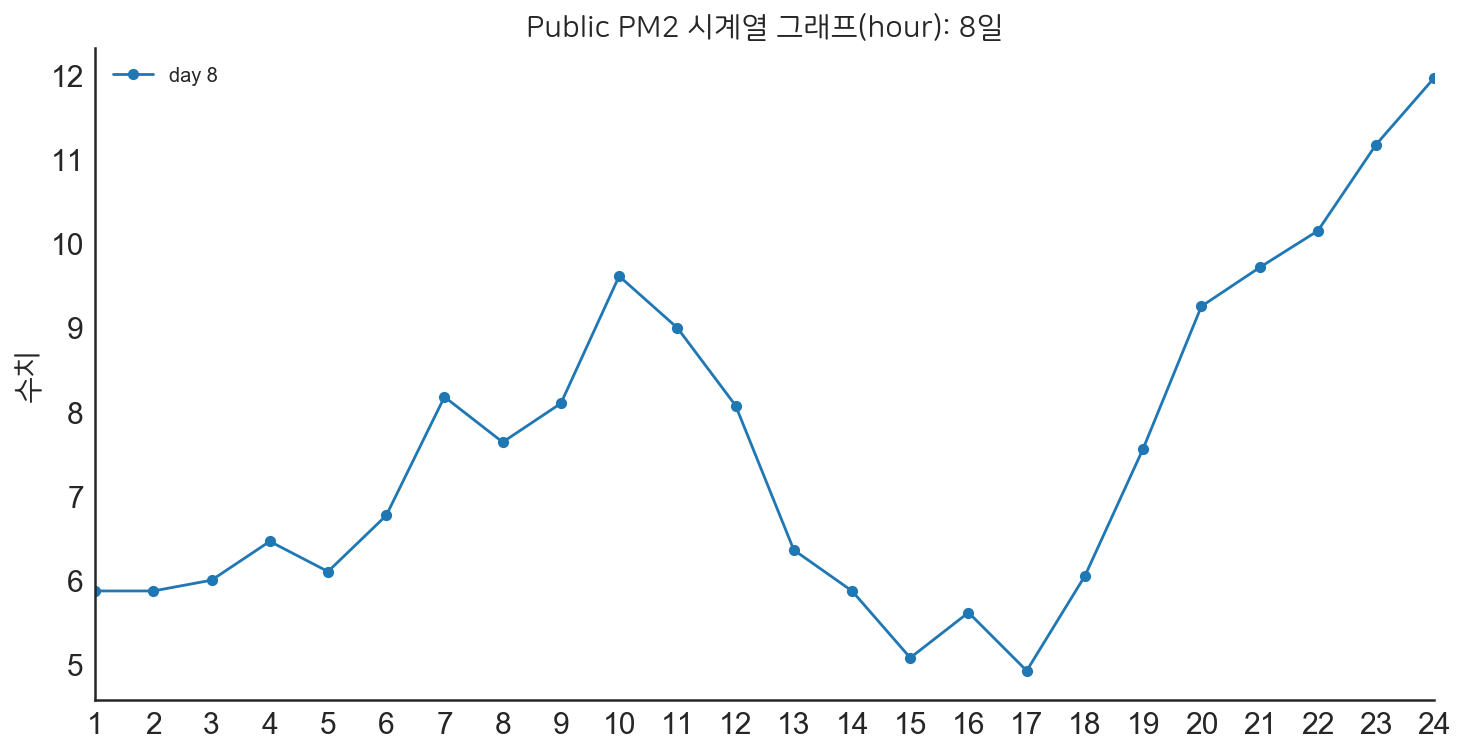

In [92]:
public_graph_of_PM2(8)

# *Airbee 데이터 PM2 평균 시계열 (전체 데이터 대상)

In [94]:
def time_graph_of_PM2(out, year, month, day):
    # 그래프
    plt.figure(figsize = (12,6))
    graph_PM2 = out[(out['DAY']==day)&(out['MONTH']==month)&(out['YEAR']==year)].groupby('HOUR')['PM2'].mean().plot(marker = 'o')
    
    sns.despine()
    plt.tick_params(labelsize=15) 
    graph_PM2.set_ylabel('수치',fontproperties=fontprop)
    graph_PM2.set_title('PM2 시계열 그래프(hour): {}년 {}월 {}일'.format(year, month, day),fontproperties=fontprop)
    plt.xticks(np.arange(24)+1, xtick)
#     plt.ylim(0,80)
    plt.hlines(25,0,24, label = '25',linestyle= 'dashed', color = 'g')
    plt.hlines(50,0,24, label = '50',linestyle= 'dashed', color ='r')
    plt.legend(fontsize = 10)
    plt.grid(False)
    plt.show()

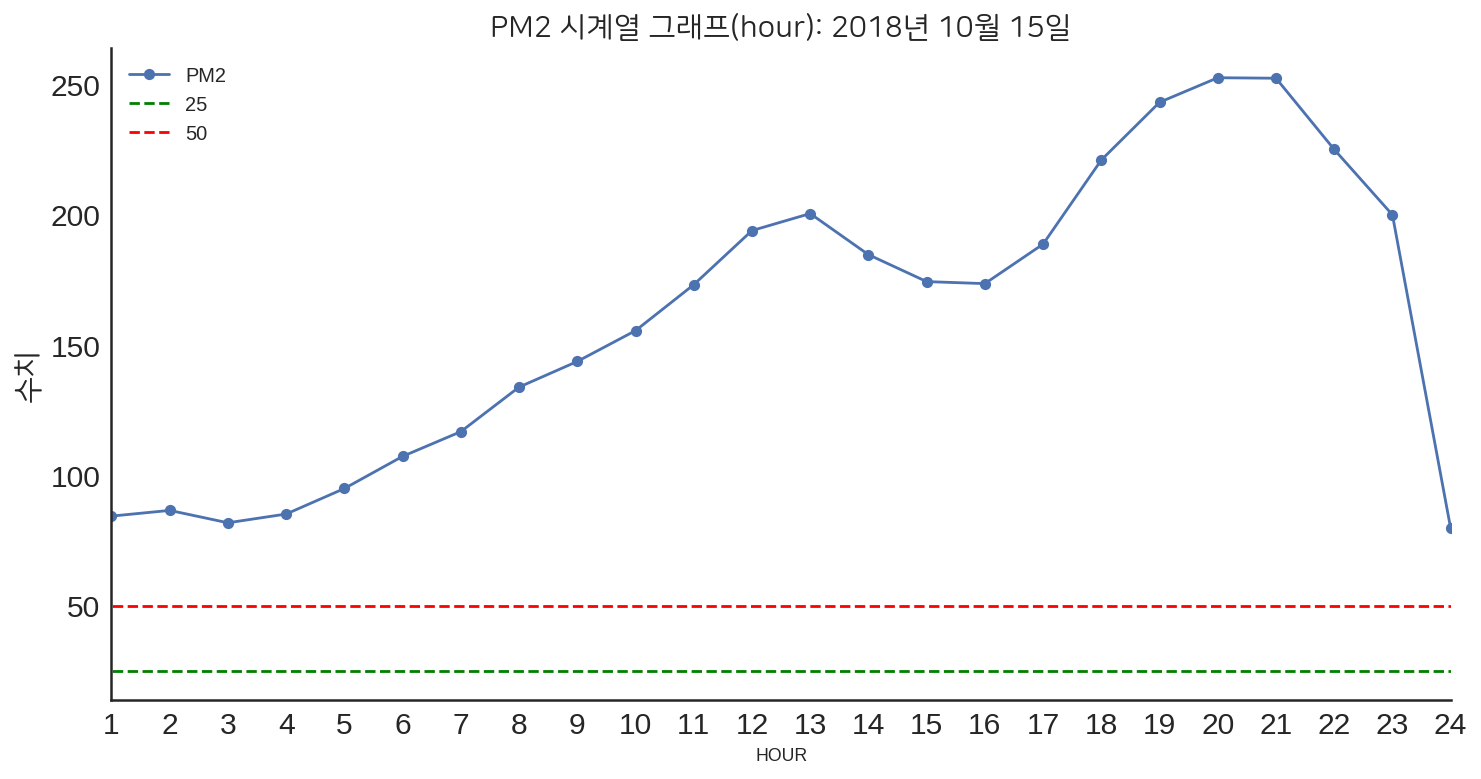

In [95]:
time_graph_of_PM2(out17,2018,10,15)

# *Airbee 데이터 PM2 평균 시계열 / 공공데이터 (서울시 데이터 대상)
- 공공데이터가 서울시 데이터 이기 때문

In [112]:
def time_graph_of_PM2_with_public_seoul(out, year,month,day):      
    # 그래프
    plt.figure(figsize = (12,6))
    graph_PM2 = out[(out['DAY']==day)&(out['MONTH']==month)&(out['YEAR']==year) & (out['REGION_1']=='서울특별시')].groupby('HOUR')['PM2'].mean().plot(marker = 'o')
    plt.plot(public[day], marker = 'o', label = 'Public(Seoul)')
    
    sns.despine()
    plt.tick_params(labelsize=15) 
    graph_PM2.set_ylabel('수치',fontproperties=fontprop)
    graph_PM2.set_title('PM2 시계열 그래프(hour): {}년 {}월 {}일'.format(year,month,day),fontproperties=fontprop)
    plt.xticks(np.arange(24)+1, xtick)
#     plt.ylim(0,80)
    plt.hlines(25,0,24, label = '25',linestyle= 'dashed', color = 'g')
    plt.hlines(50,0,24, label = '50',linestyle= 'dashed', color ='r')
    plt.legend(fontsize = 10)
    plt.grid(False)
    plt.show()

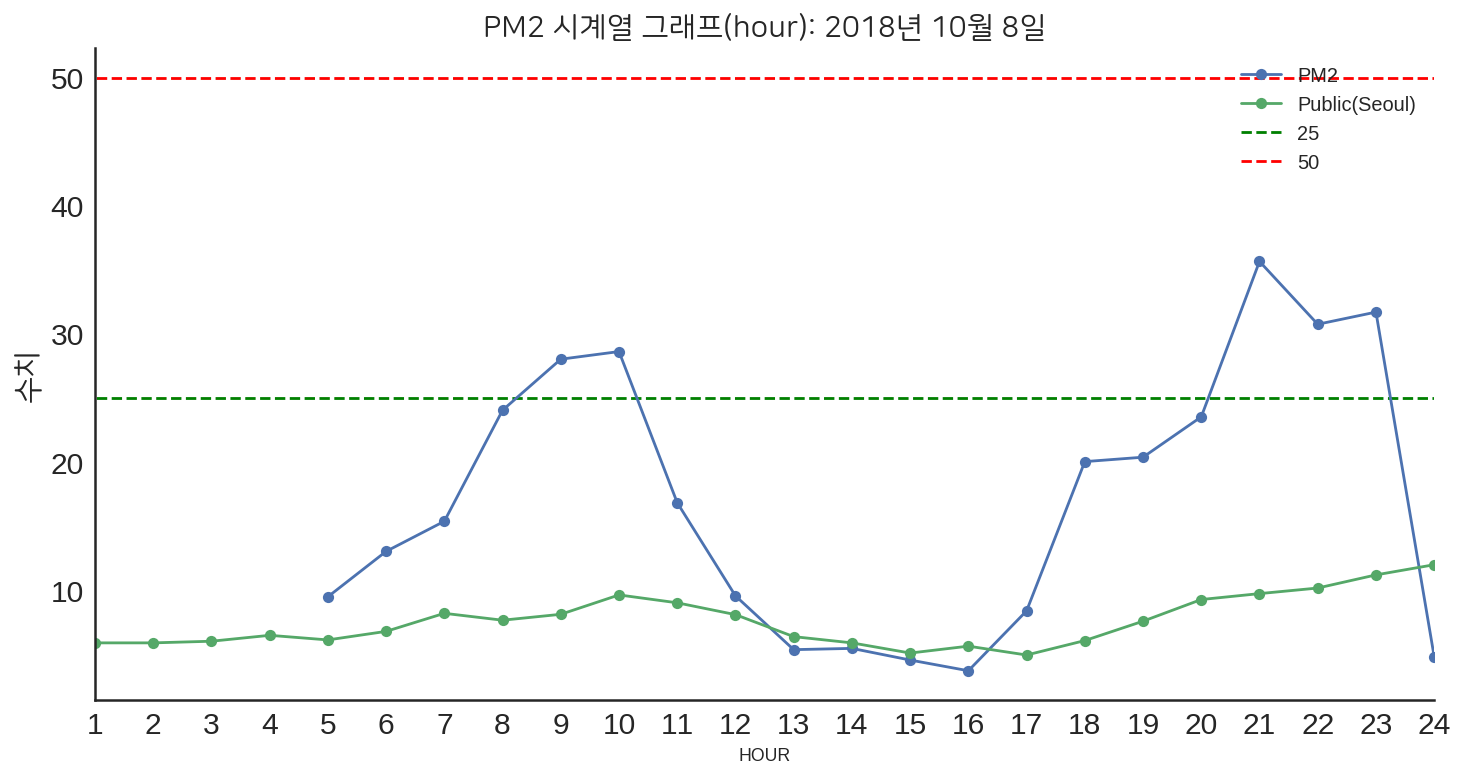

In [113]:
time_graph_of_PM2_with_public_seoul(out_until181016,2018,10,8)

# *Airbee 데이터 PM2 평균 시계열 / 공공데이터 (전체 데이터 대상)

In [115]:
def time_graph_of_PM2_with_public(out, year, month, day):    
    # 그래프
    plt.figure(figsize = (12,6))
    graph_PM2 = out[(out['DAY']==day)&(out['MONTH']==month)&(out['YEAR']==year)].groupby('HOUR')['PM2'].mean().plot(marker = 'o')
    plt.plot(public[day], marker = 'o', label = 'Public')
    
    sns.despine()
    plt.tick_params(labelsize=15) 
    graph_PM2.set_ylabel('수치',fontproperties=fontprop)
    graph_PM2.set_title('PM2 시계열 그래프(hour): {}년 {}월 {}일'.format(year, month, day),fontproperties=fontprop)
    plt.xticks(np.arange(24)+1, xtick)
#     plt.ylim(0,80)
    plt.hlines(25,0,24, label = '25',linestyle= 'dashed', color = 'g')
    plt.hlines(50,0,24, label = '50',linestyle= 'dashed', color ='r')
    plt.legend(fontsize = 10)
    plt.grid(False)
    plt.show()

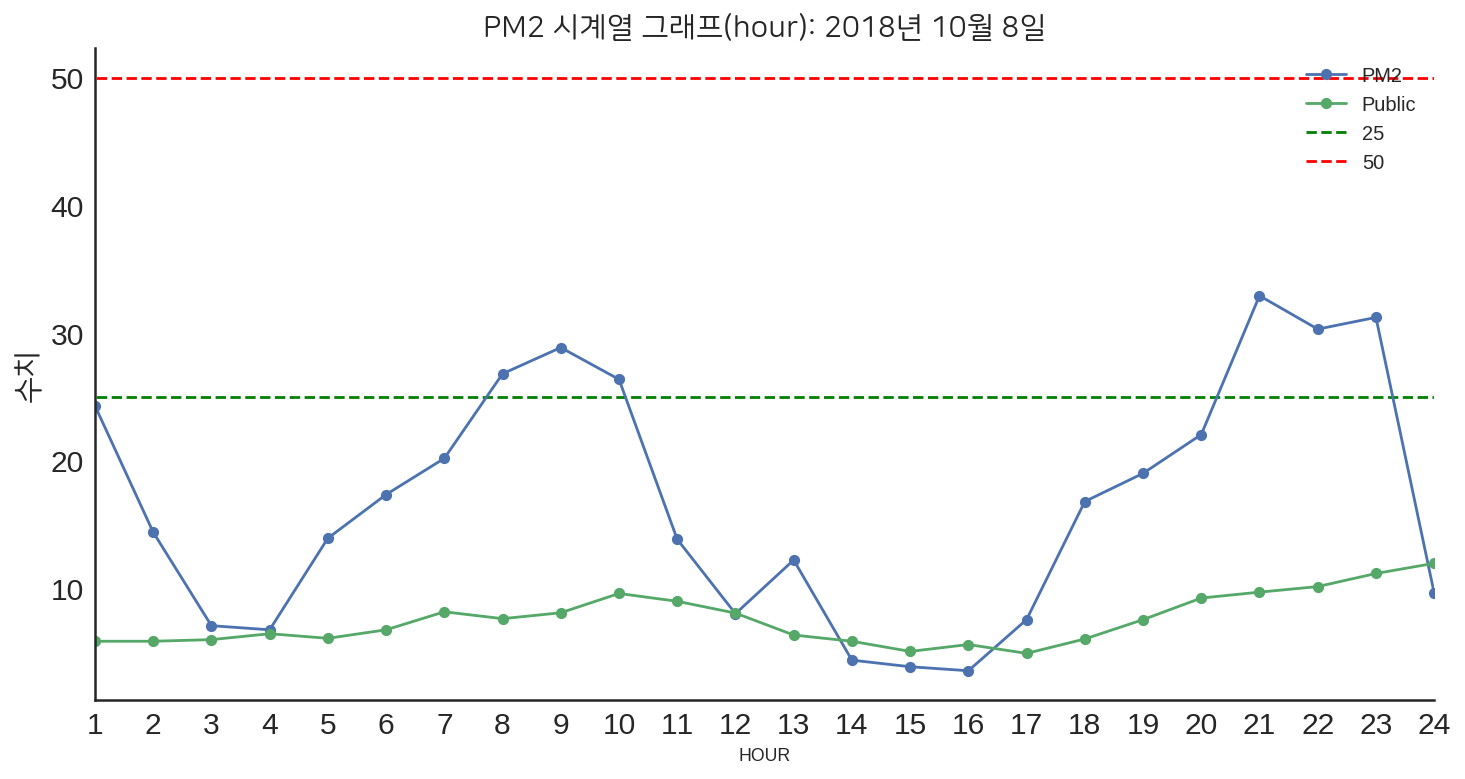

In [116]:
time_graph_of_PM2_with_public(out_until181016,2018,10,8)

# *Airbee 데이터 PM2 평균 시계열 / 공공데이터 (서울시 데이터 대상) twinx
#### -  airbee와 공공데이터의 시간별 추이를 비교하기 위한 시각화
#### - 수치의 절대적인 부분은 차이가 있지만 유사한 flow를 가졌다고 생각

In [118]:
def graph_twinx(out, year, month, day):
    plt.figure(figsize = (12,6))
    graph_PM2 = out[(out['DAY']==day)&(out['MONTH']==month)&(out['YEAR']==year)&(out['REGION_1']=='서울특별시')].groupby('HOUR')['PM2'].mean().plot()
    graph_PM2.set_ylabel('수치(Airbee)',fontproperties=fontprop)
    graph_PM2.set_title('PM2 시계열 그래프(hour): {}년 {}월 {}일'.format(year, month, day),fontproperties=fontprop)

    ax = graph_PM2.twinx()
    ax.plot(public[day], label = 'Public(Seoul)', color = 'r')
    ax.set_ylabel('수치(public)',fontproperties=fontprop)

    plt.xticks(np.arange(24)+1, xtick)
    plt.legend(fontsize = 10, loc = 'lower right')
    plt.grid(False)
    plt.show()

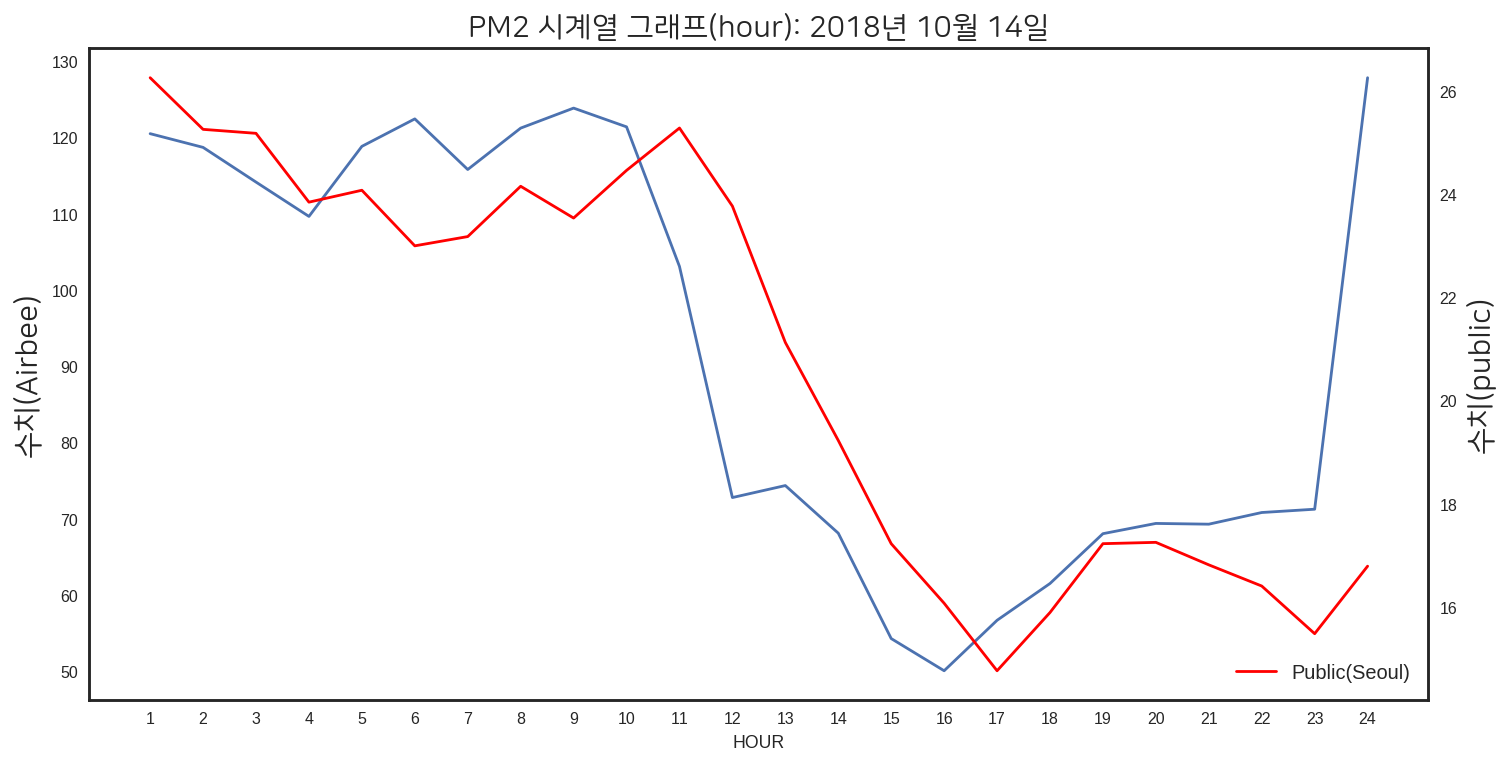

In [161]:
graph_twinx(out_until181016,2018, 10, 14)

# 2. TEMPER, HUMI

In [131]:
def PM2_and_TEMPER_graph(out,x):
    plt.figure(figsize = (10,10))
    a = out[out['PM2'] < x]
    plt.scatter(a['TEMPER'], a['PM2'], s = 3)
    sns.despine()
    plt.tick_params(labelsize=15) 
    plt.xlabel('TEMPER',fontproperties=fontprop)
    plt.ylabel('PM2',fontproperties=fontprop)
    plt.title('PM2, TEMPER scatter 그래프',fontproperties=fontprop)
    plt.grid(False)
    plt.show()

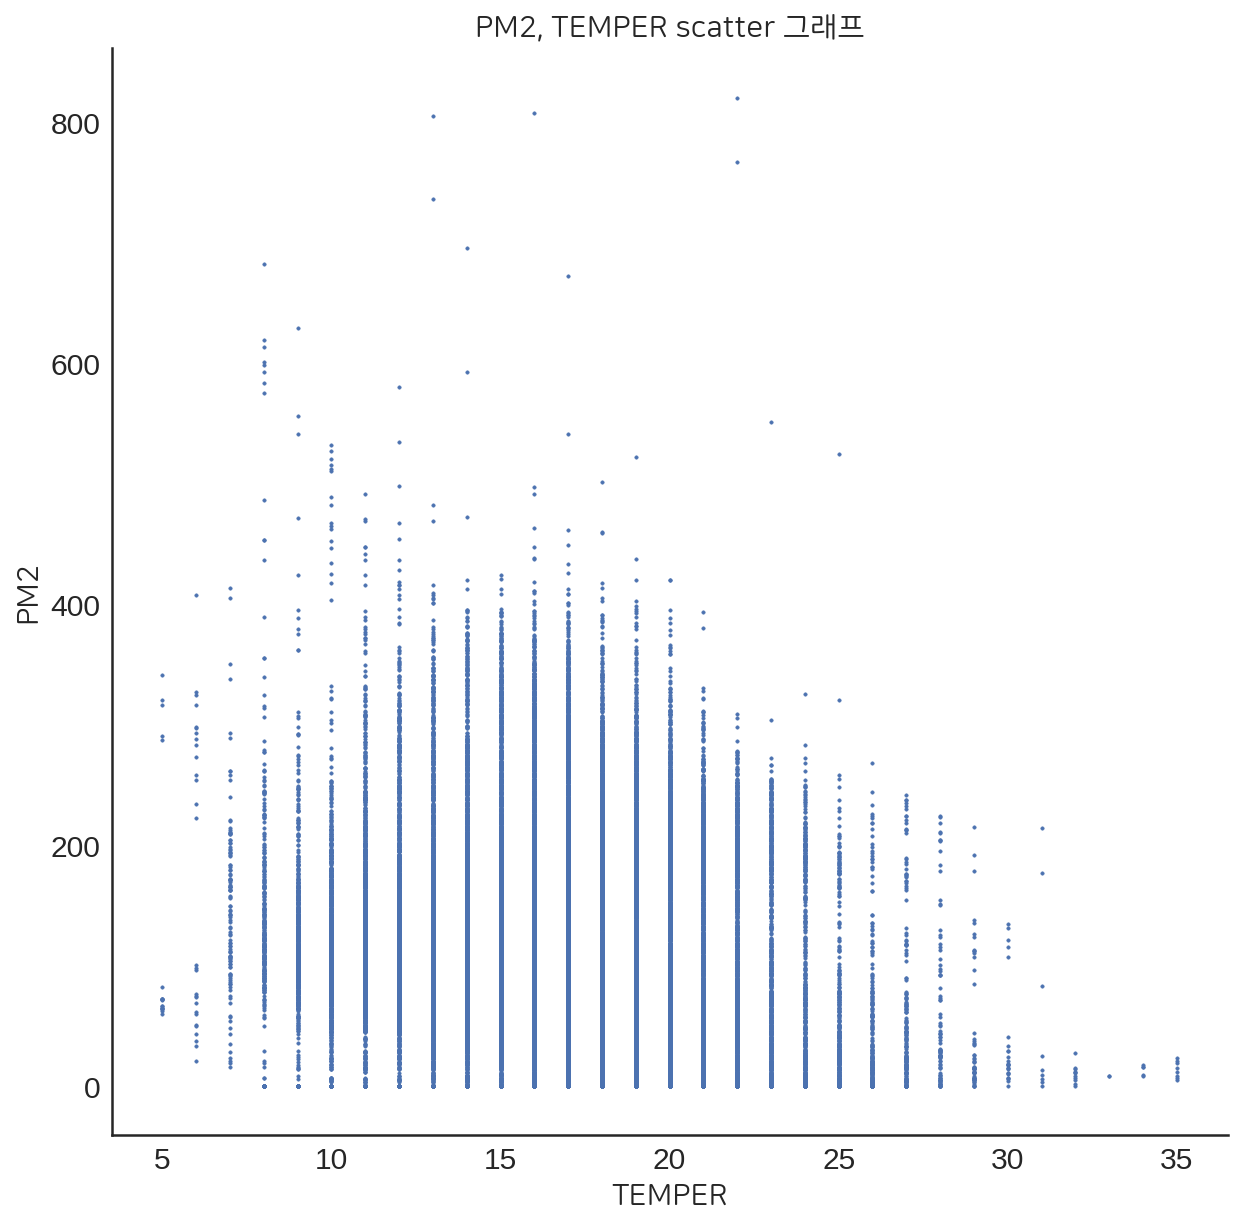

In [132]:
# PM2가 200 이하인 경우만 고려
PM2_and_TEMPER_graph(out17,999)

In [133]:
def PM2_and_HUMI_graph(out, x):
    plt.figure(figsize = (10,10))
    a = out[out['PM2'] < x]
    plt.scatter(a['HUMI'], a['PM2'], s = 3)
    sns.despine()
    plt.tick_params(labelsize=15) 
    plt.xlabel('HUMI',fontproperties=fontprop)
    plt.ylabel('PM2',fontproperties=fontprop)
    plt.title('PM2, HUMI scatter 그래프',fontproperties=fontprop)
    plt.grid(False)
    plt.show()

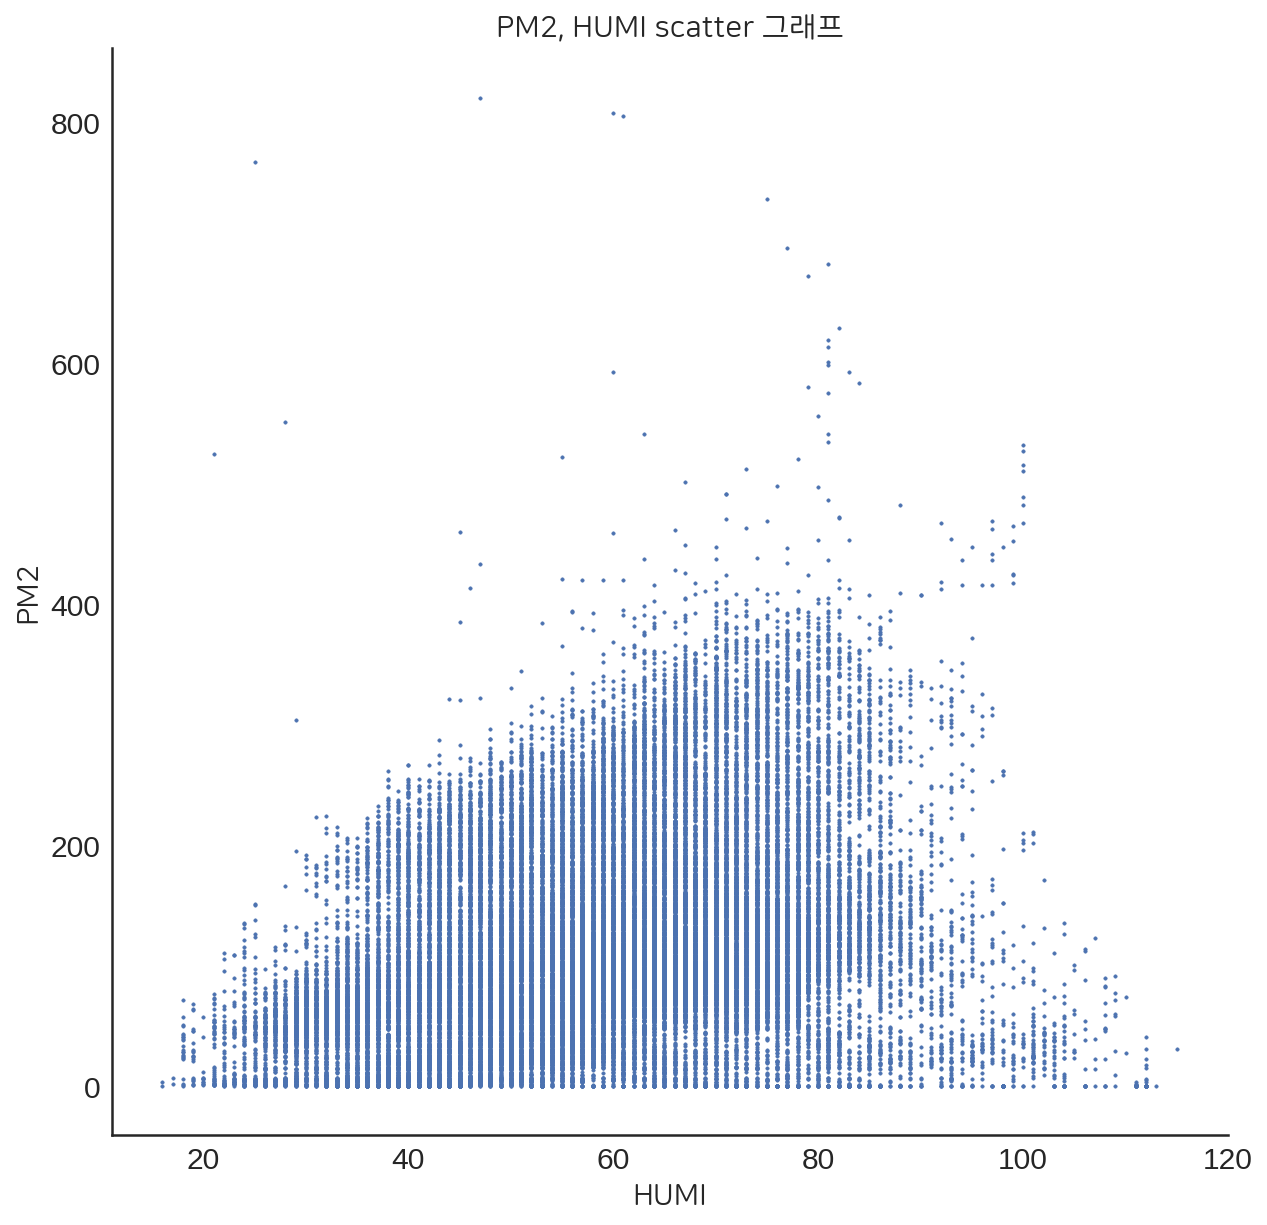

In [134]:
# PM2가 200 이하인 경우만 고려
PM2_and_HUMI_graph(out17,999)

In [136]:
def HUMI_and_TEMPER_graph(out):
    plt.figure(figsize = (10,10))
    plt.scatter(out['HUMI'], out['TEMPER'], s = 3)
    sns.despine()
    plt.tick_params(labelsize=15) 
    plt.xlabel('HUMI',fontproperties=fontprop)
    plt.ylabel('TEMPER',fontproperties=fontprop)
    plt.title('HUMI, TEMPER scatter 그래프',fontproperties=fontprop)
    plt.grid(False)
    plt.show()

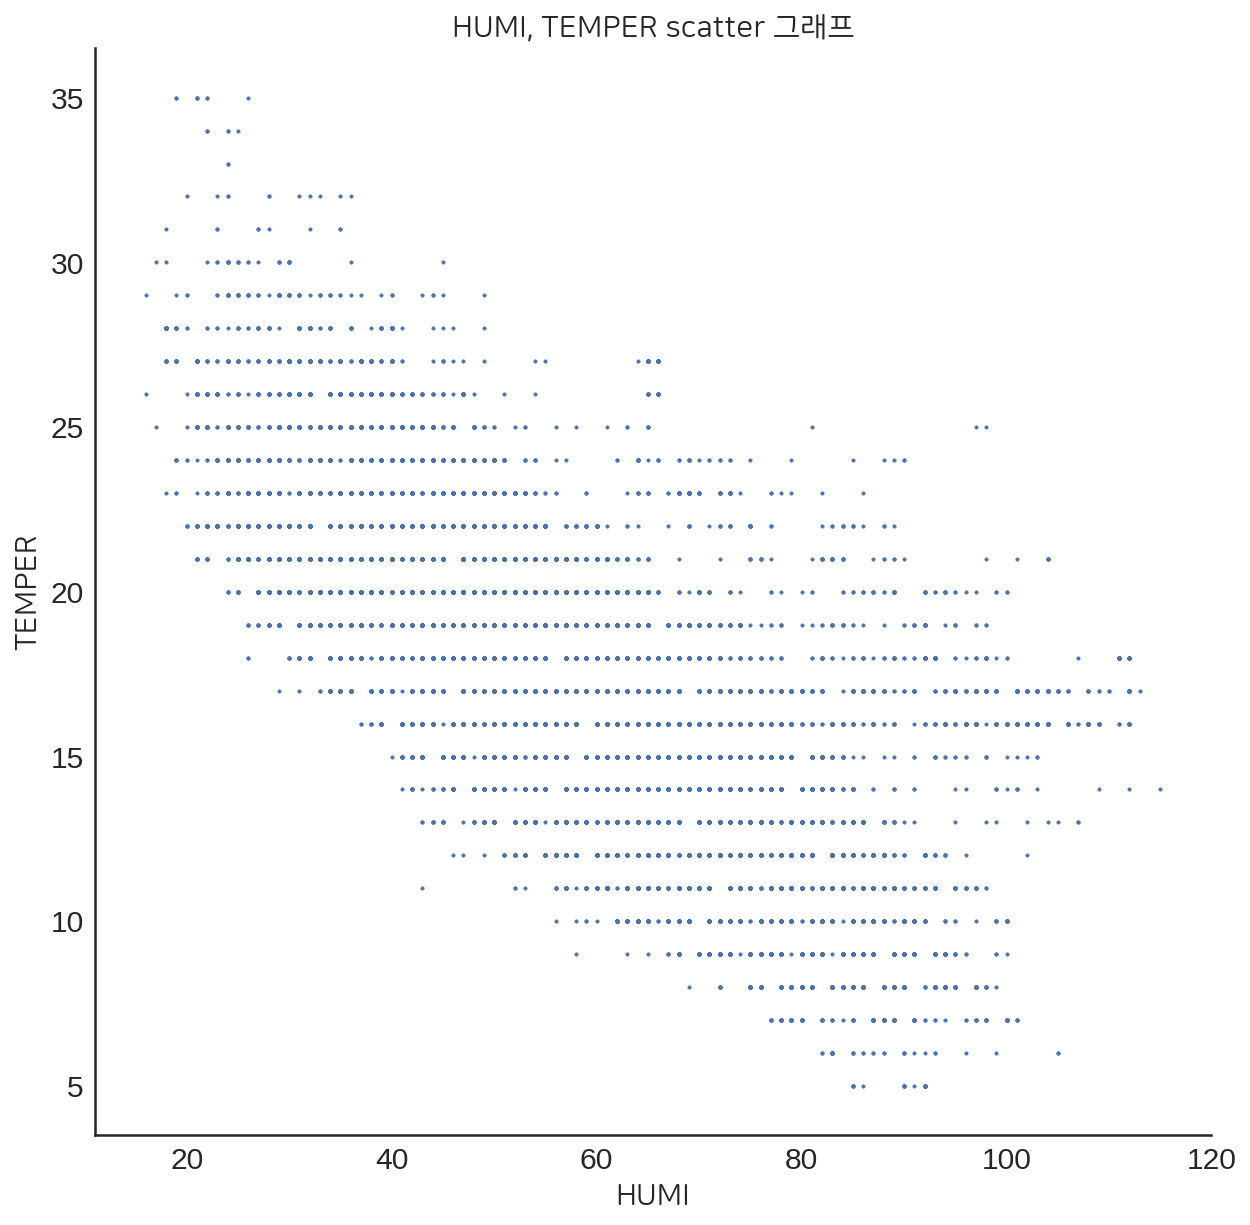

In [137]:
HUMI_and_TEMPER_graph(out17)

# 3. SPEED, ACCELERATE

- 가속도
<br>
1 : 정지
2 : 걷기
3 : 뛰기


# 4. ILLUMINATION


- 근조도
<br>
00 : 미근접 어두움
01 : 미근접 밝음
10 : 근접 어두움
11 : 근접 밝음

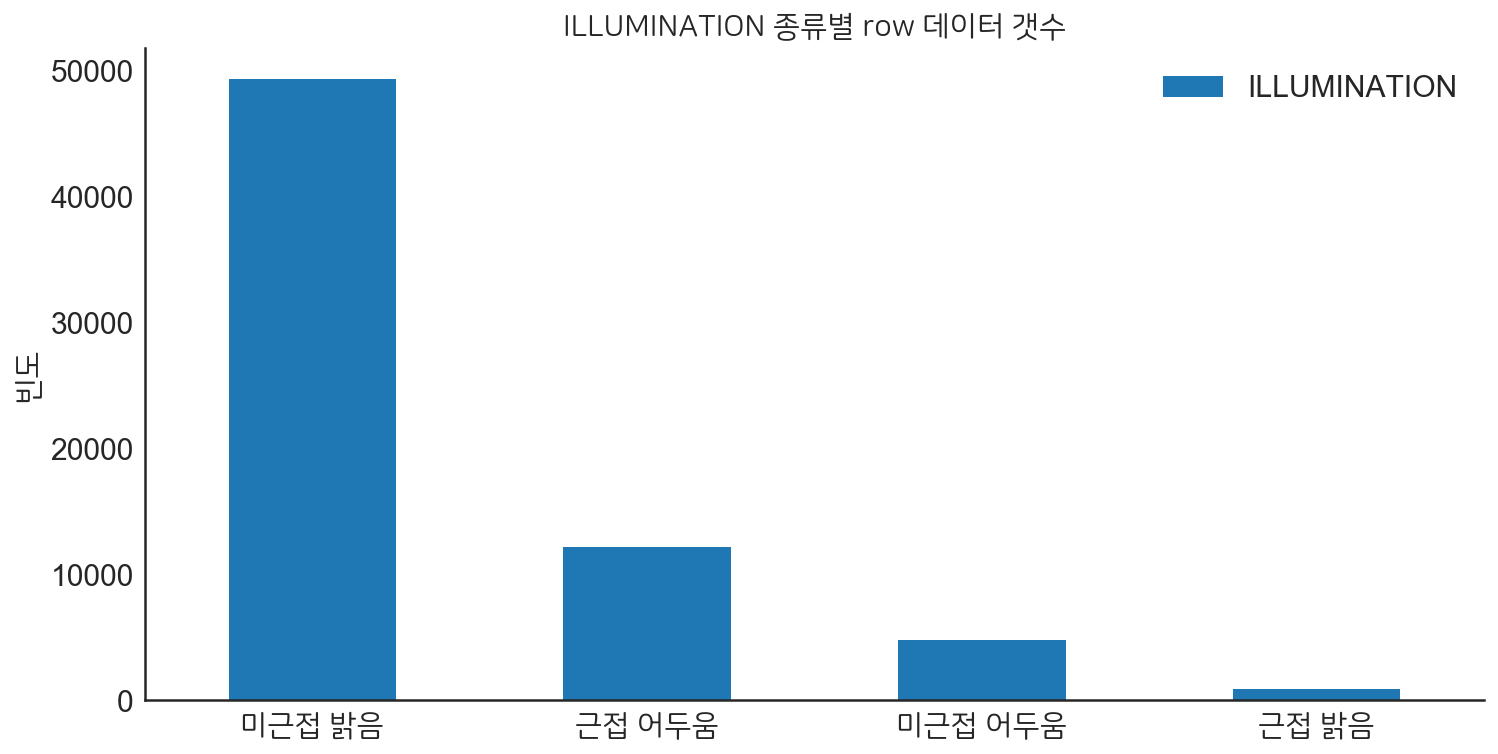

In [121]:
plt.figure(figsize = (12,6))
a = out['ILLUMINATION'].value_counts().plot.bar()
    
sns.despine()
plt.tick_params(labelsize=15) 
a.set_ylabel('빈도',fontproperties=fontprop)
a.set_xticklabels(['미근접 밝음','근접 어두움','미근접 어두움','근접 밝음'],fontproperties=fontprop)
plt.xticks(rotation = 0)
plt.title('ILLUMINATION 종류별 row 데이터 갯수',fontproperties=fontprop)
plt.legend(fontsize = 15)
plt.grid(False)
plt.show()

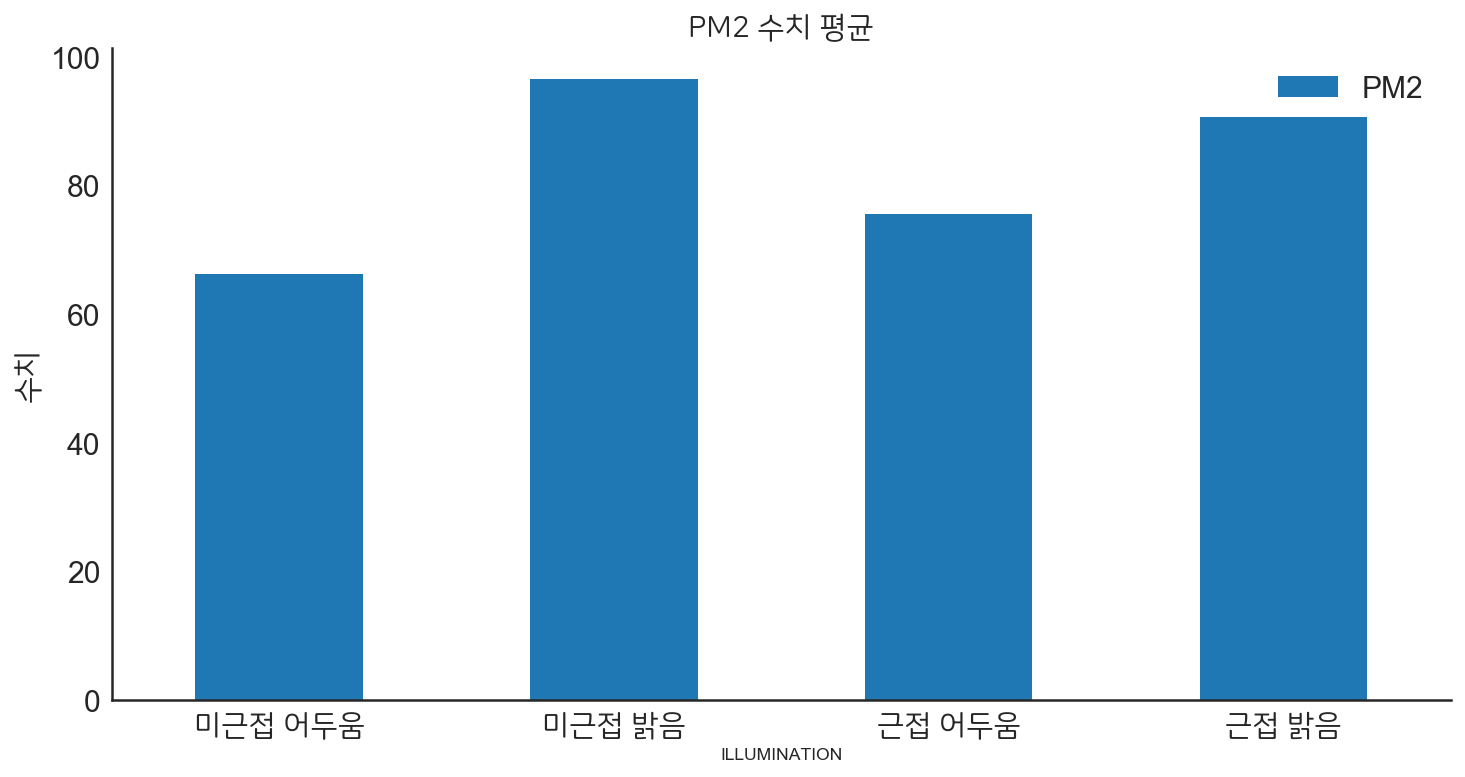

In [122]:
plt.figure(figsize = (12,6))
a = out.groupby('ILLUMINATION')['PM2'].mean().plot.bar()
sns.despine()
plt.tick_params(labelsize=15) 
a.set_ylabel('수치',fontproperties=fontprop)
a.set_xticklabels(['미근접 어두움','미근접 밝음','근접 어두움','근접 밝음'],fontproperties=fontprop)
plt.title('PM2 수치 평균',fontproperties=fontprop)
plt.xticks(rotation = 0)
plt.legend(fontsize = 15)
plt.grid(False)
plt.show()

# 5. REGION

In [143]:
def region_graph(out):
    xticks = out.REGION_2.value_counts().index
    plt.figure(figsize = (12,8))
    a = out.REGION_2.value_counts().plot.bar()
    sns.despine()
    plt.tick_params(labelsize=10) 
    a.set_xticklabels(xticks,fontproperties=fontprop, fontsize = 10)
    plt.xticks(rotation = 90)
    plt.xlabel('지역',fontproperties=fontprop)
    plt.ylabel('빈도수',fontproperties=fontprop)
    plt.title('지역별 데이터 row 갯수',fontproperties=fontprop, fontsize = 20)
    plt.grid(False)
    plt.show()

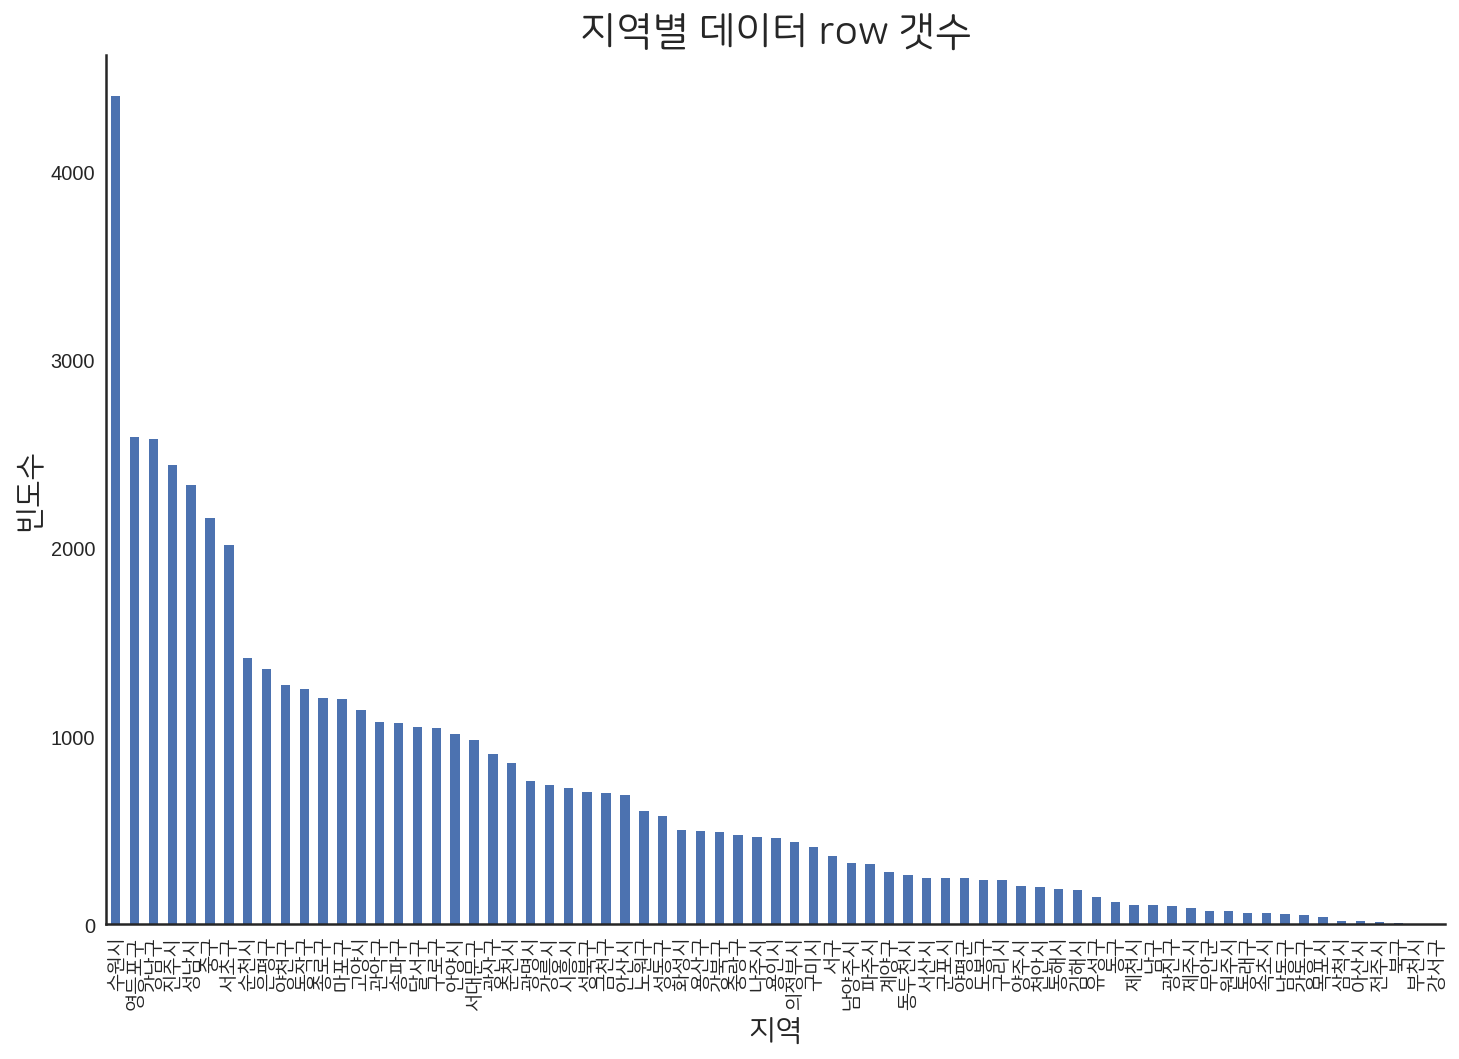

In [144]:
region_graph(out17)

In [140]:
def city_graph_of_PM2(out, year, month, day, city):
    # 그래프
    plt.figure(figsize = (12,6))
    graph_PM2 = out[(out['DAY']==day)&(out['MONTH']==month)&(out['YEAR']==year)&(out['REGION_2']==city)].groupby('HOUR')['PM2'].mean().plot(marker = 'o')
    
    sns.despine()
    plt.tick_params(labelsize=15) 
    graph_PM2.set_ylabel('수치',fontproperties=fontprop)
    graph_PM2.set_title('PM2 시계열 그래프(hour): {}년 {}월 {}일 {}데이터'.format(year, month, day,city),fontproperties=fontprop)
    plt.xticks(np.arange(24)+1, xtick)
#     plt.ylim(0,80)
    plt.hlines(25,0,24, label = '25',linestyle= 'dashed', color = 'g')
    plt.hlines(50,0,24, label = '50',linestyle= 'dashed', color ='r')
    plt.legend(fontsize = 10)
    plt.grid(False)
    plt.show()

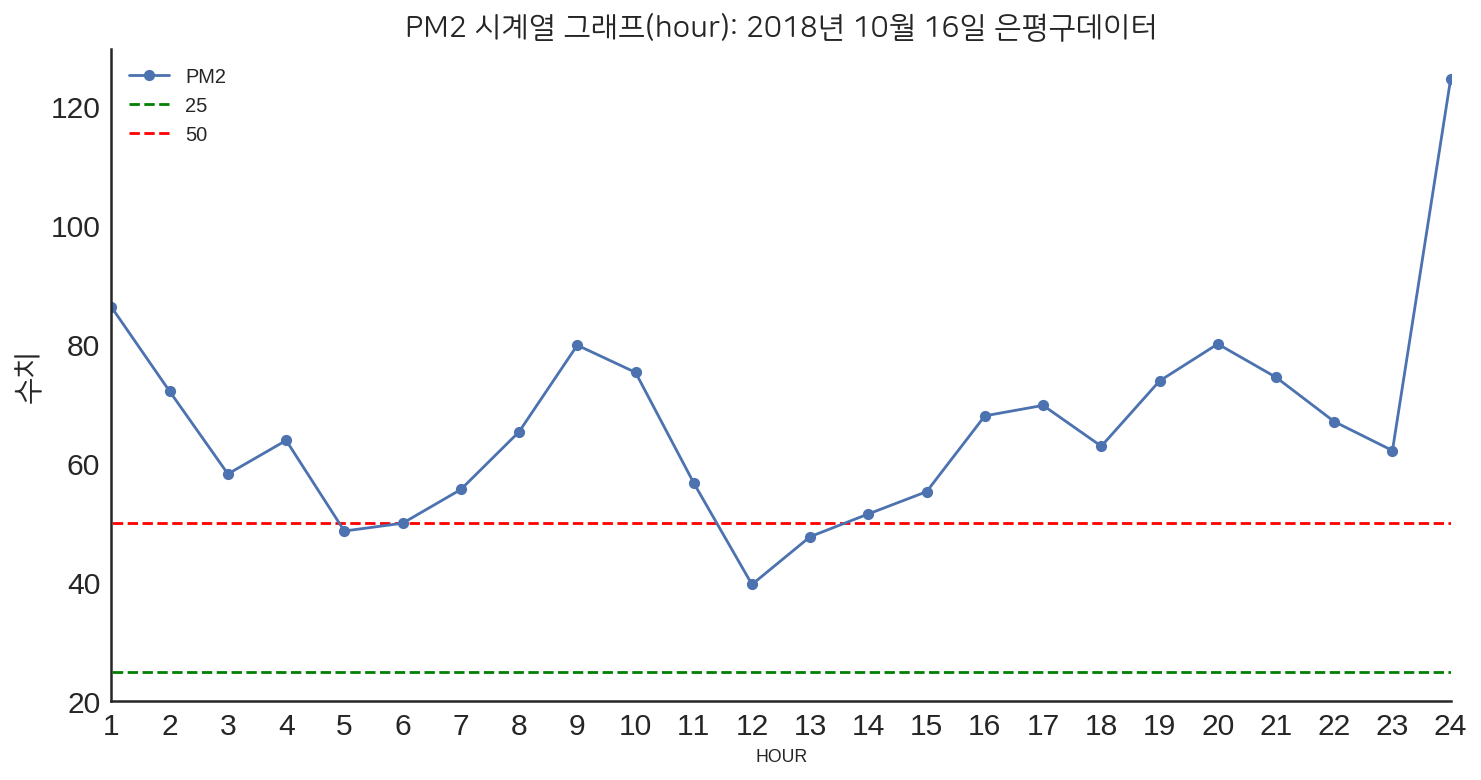

In [142]:
city_graph_of_PM2(out17, 2018,10,16,'은평구')

## * 센서별 EDA

In [127]:
def sensor_graph_of_PM2(year, month, day, sensor_id):
    # 그래프
    plt.figure(figsize = (12,6))
    graph_PM2 = out[(out['DAY']==day)&(out['MONTH']==month)&(out['YEAR']==year)&(out['SENSOR_ID']==sensor_id)].groupby('HOUR')['PM2'].mean().plot(marker = 'o')
    
    sns.despine()
    plt.tick_params(labelsize=15) 
    graph_PM2.set_ylabel('수치',fontproperties=fontprop)
    graph_PM2.set_title('PM2 시계열 그래프(hour): {}년 {}월 {}일 {}데이터'.format(year, month, day,sensor_id),fontproperties=fontprop)
    plt.xticks(np.arange(24)+1, xtick)
#     plt.ylim(0,80)
    plt.hlines(25,0,24, label = '25',linestyle= 'dashed', color = 'g')
    plt.hlines(50,0,24, label = '50',linestyle= 'dashed', color ='r')
    plt.legend(fontsize = 10)
    plt.grid(False)
    plt.show()

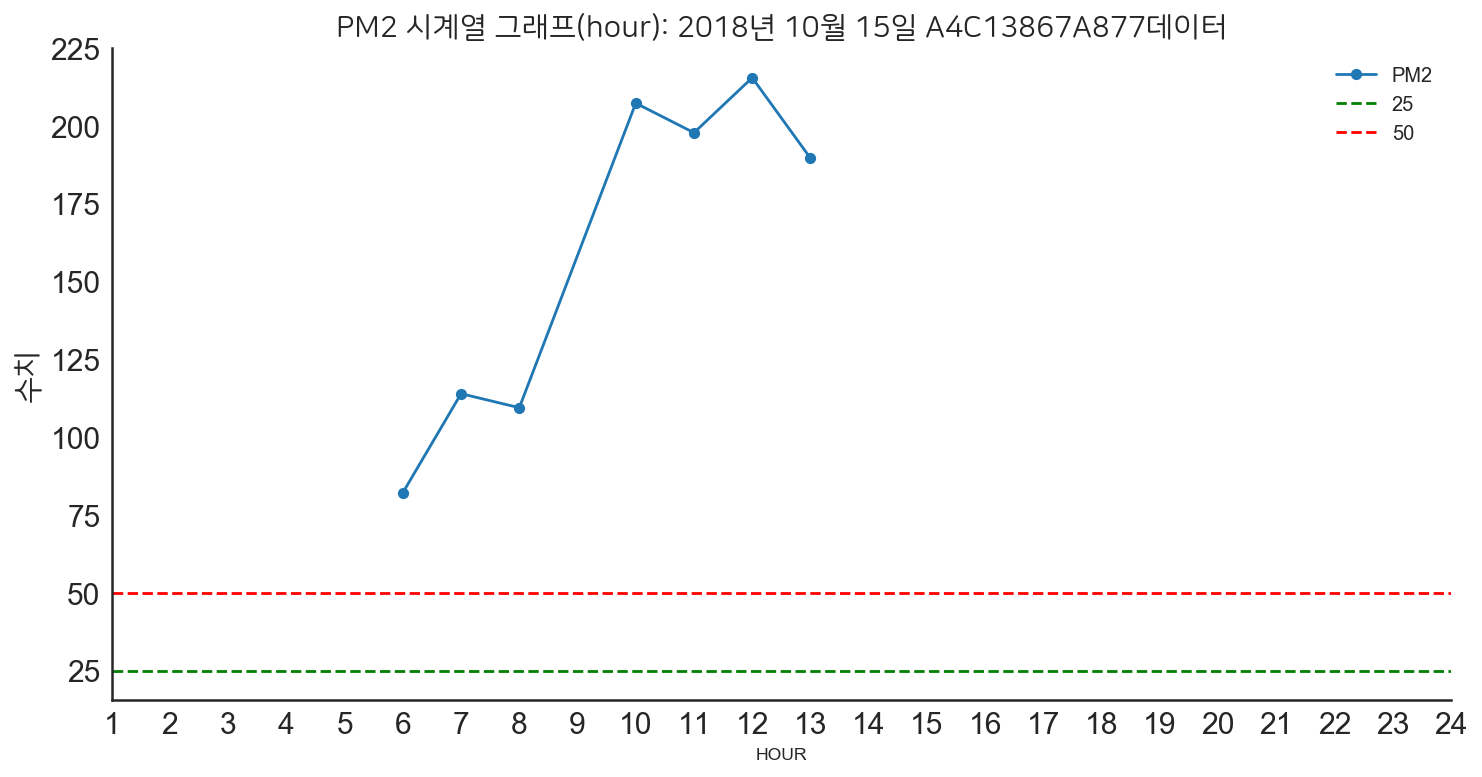

In [128]:
sensor_graph_of_PM2(2018,10,15,'A4C13867A877')